In [1]:
!pip install -q kaggle --quiet


In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d wardaddy24/marble-surface-anomaly-detection-2

 90%|██████████████████████████████████▉    | 33.0M/36.8M [00:00<00:00, 169MB/s]
100%|███████████████████████████████████████| 36.8M/36.8M [00:00<00:00, 162MB/s]


In [6]:
!unzip marble-surface-anomaly-detection-2.zip 

Archive:  marble-surface-anomaly-detection-2.zip
  inflating: dataset/test/crack/_0_0_20210531_17292_0.jpg  
  inflating: dataset/test/crack/_0_0_20210531_17293_0.jpg  
  inflating: dataset/test/crack/_0_0_20210531_17293_1.jpg  
  inflating: dataset/test/crack/_0_1280_20210525_14425.jpg  
  inflating: dataset/test/crack/_0_1280_20210525_14425_0.jpg  
  inflating: dataset/test/crack/_0_1280_20210525_14462_0.jpg  
  inflating: dataset/test/crack/_0_1536_20210525_14462.jpg  
  inflating: dataset/test/crack/_0_2304_20210525_14425_1.jpg  
  inflating: dataset/test/crack/_0_2560_20210525_13375_0.jpg  
  inflating: dataset/test/crack/_0_2560_20210525_14425_0.jpg  
  inflating: dataset/test/crack/_0_3072_20210525_15144_2.jpg  
  inflating: dataset/test/crack/_0_3072_20210525_15144_3.jpg  
  inflating: dataset/test/crack/_0_3840_20210531_10554.jpg  
  inflating: dataset/test/crack/_0_3840_20210531_10554_2.jpg  
  inflating: dataset/test/crack/_0_4096_20210531_11271_2.jpg  
  inflating: dataset/

In [11]:
!pip install opencv-python --quiet

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow 
import keras as ks
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [64]:
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path', 'image_labels'])
    for label in os.listdir(folder_path):
        label_dir = os.path.join(folder_path, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                if label != 'good':  # Check if the label is not 'good'
                    label = 'defect'  # Change the label to 'defect'
                sig = sig.append({'image_abs_path': image_path,
                                  'image_labels': label},
                                 ignore_index=True)
    return sig

dataset_dir = 'dataset/train'
output_file = 'train_dataset.csv'

train_data = getdata(dataset_dir)
train_data.to_csv(output_file, index=False)
train_data

,image_abs_path,image_labels
0,dataset/train/good/_1792_3072_20210525_15434.jpg,good
1,dataset/train/good/_1536_4352_20210531_11192.jpg,good
2,dataset/train/good/_1280_256_20210531_11194.jpg,good
3,dataset/train/good/_1536_2560_20210525_15434.jpg,good
4,dataset/train/good/_1792_2048_65.jpg,good
...,...,...
2246,dataset/train/dot/_3584_1024_20210531_17301_1.jpg,defect
2247,dataset/train/dot/_512_4096_20210525_15175_1.jpg,defect
2248,dataset/train/dot/_1024_512_20210531_10521_2.jpg,defect
2249,dataset/train/dot/_256_1792_20210531_10561_0.jpg,defect


In [63]:
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path', 'image_labels'])
    for label in os.listdir(folder_path):
        label_dir = os.path.join(folder_path, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                if label != 'good':  # Check if the label is not 'good'
                    label = 'defect'  # Change the label to 'defect'
                sig = sig.append({'image_abs_path': image_path,
                                  'image_labels': label},
                                 ignore_index=True)
    return sig

dataset_dir = 'dataset/test'
output_file = 'test_dataset.csv'

test_data = getdata(dataset_dir)
test_data.to_csv(output_file, index=False)
test_data

,image_abs_path,image_labels
0,dataset/test/good/_256_3840_20210525_154.jpg,good
1,dataset/test/good/_1280_0_20210525_15441.jpg,good
2,dataset/test/good/_1280_3584_20210531_11194.jpg,good
3,dataset/test/good/_1024_3584_65.jpg,good
4,dataset/test/good/_256_4096_20210531_11274.jpg,good
...,...,...
684,dataset/test/dot/_256_1024_20210531_10561_1.jpg,defect
685,dataset/test/dot/_0_3328_20210525_14432_0.jpg,defect
686,dataset/test/dot/_1792_1024_20210525_15175_0.jpg,defect
687,dataset/test/dot/_2560_1280_20210531_17292_2.jpg,defect


## Selecting the defect and good labels 

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess(dataframe, bsize):
    train_gen = ImageDataGenerator(
        rescale=1.0 / 255,
        zoom_range=0.2,
        shear_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
    )
    
    sig = pd.DataFrame(columns=['image_abs_path', 'image_labels'])
    for index, row in dataframe.iterrows():
        image_path = row['image_abs_path']
        image_label = row['image_labels']
        sig = sig.append({'image_abs_path': image_path,
                          'image_labels': image_label},
                         ignore_index=True)
    
    data_generator = train_gen.flow_from_dataframe(
        dataframe=sig,
        x_col='image_abs_path',
        y_col='image_labels',
        target_size=(48, 48),
        batch_size=bsize,
        color_mode='rgb',
        shuffle=True,
        class_mode='binary',
        classes=['defect', 'good'],
    )
    
    return data_generator

train_data = pd.read_csv('train_dataset.csv')  
test_data = pd.read_csv('test_dataset.csv')  

batch_size = 16  
train_gen = preprocess(train_data, batch_size)
valid_gen = preprocess(test_data, batch_size)


Found 2249 validated image filenames belonging to 2 classes.
Found 688 validated image filenames belonging to 2 classes.


In [68]:
def visualize_gen(train_generator):   
    plt.figure(figsize=(6, 3))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]        
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8))
            break
    plt.tight_layout()
    plt.show()

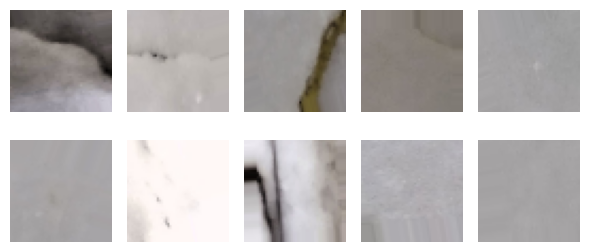

In [76]:
visualize_gen(valid_gen)

In [75]:
input_shape = train_gen.image_shape
input_shape

(48, 48, 3)

# Model Architecture

In [84]:
from tensorflow import keras as ks

model01 = ks.models.Sequential()

# Adding layers
model01.add(ks.layers.Conv2D(16, (3, 3), strides=1, activation="relu", padding='same', input_shape=input_shape))
model01.add(ks.layers.MaxPooling2D(pool_size=2, strides=2))
model01.add(ks.layers.Dropout(0.2))

model01.add(ks.layers.Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
model01.add(ks.layers.MaxPooling2D(pool_size=2, strides=2))

model01.add(ks.layers.Flatten())
model01.add(ks.layers.Dense(128, activation="relu"))
model01.add(ks.layers.Dropout(0.2))

model01.add(ks.layers.Dense(1, activation="sigmoid"))

model01.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 16)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4608)             

In [85]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=20, verbose=2,restore_best_weights=True)

optimizer = tensorflow.optimizers.Adam(learning_rate=0.0001)

model01.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])

history = model01.fit(train_gen, epochs=100, callbacks=callback, validation_data=valid_gen, verbose=1)


Epoch 1/100
141/141 [==============================] - 8s 50ms/step - loss: 0.6793 - accuracy: 0.6118 - val_loss: 0.6951 - val_accuracy: 0.5058
Epoch 2/100
141/141 [==============================] - 7s 47ms/step - loss: 0.6767 - accuracy: 0.6123 - val_loss: 0.6962 - val_accuracy: 0.5058
Epoch 3/100
141/141 [==============================] - 7s 47ms/step - loss: 0.6725 - accuracy: 0.6181 - val_loss: 0.7005 - val_accuracy: 0.5058
Epoch 4/100
141/141 [==============================] - 7s 50ms/step - loss: 0.6727 - accuracy: 0.6176 - val_loss: 0.6943 - val_accuracy: 0.5058
Epoch 5/100
141/141 [==============================] - 7s 48ms/step - loss: 0.6719 - accuracy: 0.6176 - val_loss: 0.7054 - val_accuracy: 0.5058
Epoch 6/100
141/141 [==============================] - 7s 47ms/step - loss: 0.6701 - accuracy: 0.6176 - val_loss: 0.6965 - val_accuracy: 0.5058
Epoch 7/100
141/141 [==============================] - 7s 47ms/step - loss: 0.6670 - accuracy: 0.6176 - val_loss: 0.6967 - val_accuracy:

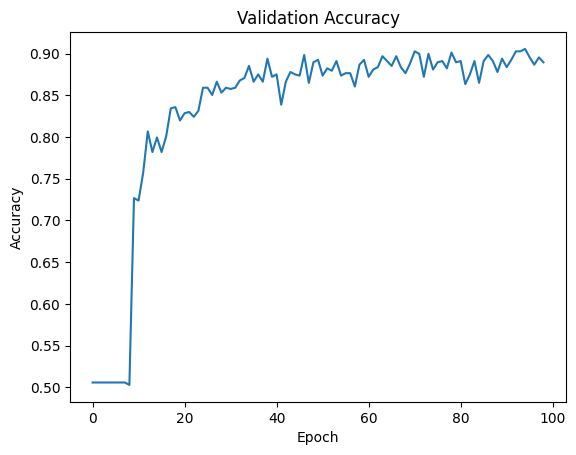

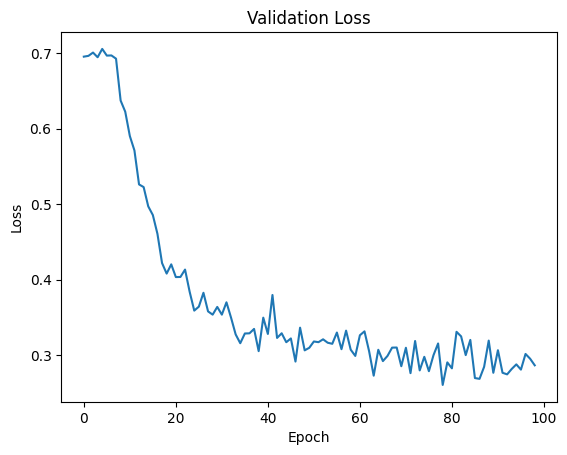

In [86]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [87]:

history = model01.fit(train_gen, initial_epoch=99,epochs=200, callbacks=callback, validation_data=valid_gen, verbose=1)


Epoch 100/200
141/141 [==============================] - 7s 49ms/step - loss: 0.2555 - accuracy: 0.8946 - val_loss: 0.2665 - val_accuracy: 0.8953
Epoch 101/200
141/141 [==============================] - 7s 48ms/step - loss: 0.2394 - accuracy: 0.9071 - val_loss: 0.2998 - val_accuracy: 0.8924
Epoch 102/200
141/141 [==============================] - 7s 49ms/step - loss: 0.2586 - accuracy: 0.8915 - val_loss: 0.3008 - val_accuracy: 0.8939
Epoch 103/200
141/141 [==============================] - 7s 49ms/step - loss: 0.2408 - accuracy: 0.9071 - val_loss: 0.2907 - val_accuracy: 0.8983
Epoch 104/200
141/141 [==============================] - 7s 49ms/step - loss: 0.2333 - accuracy: 0.9097 - val_loss: 0.2992 - val_accuracy: 0.8881
Epoch 105/200
141/141 [==============================] - 7s 52ms/step - loss: 0.2455 - accuracy: 0.9048 - val_loss: 0.2910 - val_accuracy: 0.8939
Epoch 106/200
141/141 [==============================] - 7s 48ms/step - loss: 0.2495 - accuracy: 0.8982 - val_loss: 0.2818 -

1/1 [==============================] - 0s 24ms/step


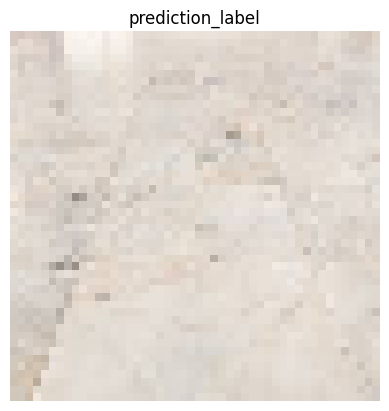

Prediction:  defect


In [93]:
import numpy as np
from tensorflow.keras.preprocessing import image
img_path = '46g.jpg'
image_size = (48, 48)  

class_names = list(valid_gen.class_indices.keys())
img = image.load_img(img_path, target_size=image_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

def predict(image):
    predictions = model01.predict(image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

predictions= predict(x)

plt.imshow(img)
plt.title('prediction_label')
plt.axis('off')
plt.show()
print("Prediction: ", predictions)

In [94]:
from google.cloud import storage
import pickle

storage_client = storage.Client()

bucket = storage_client.bucket('cloud-ai-platform-5734b953-00ea-4818-b5b7-3420cd51a628')

blob = bucket.blob('marble_class_model.pkl')

with open('marble_class_model.pkl', 'wb') as f:
    pickle.dump(model01, f)

blob.upload_from_filename('marble_class_model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-05-29 18:02:51           64
